#1.Librerías

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#2.Datos

In [3]:
#setear con google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
db_path='/content/drive/MyDrive/FCEN_DMEYF/DB'

In [5]:
modelos_path='/content/drive/MyDrive/FCEN_DMEYF/Modelos/'

In [6]:
#seteo carpeta de trabajo y archivo
dataset_path = '/content/drive/MyDrive/FCEN_DMEYF/'
dataset_file = 'competencia_01_fe_v3.csv'


In [7]:
data = pd.read_csv(f"{dataset_path}/{dataset_file}")


In [8]:
#semillas y valores de ganancia
semilla=[100183,200003,300017,700001,800011]
ganancia_acierto = 273000
costo_estimulo = 7000

In [9]:
#meses
mes_train = 202104
mes_test = 202106

## Darle valor a las clases

In [10]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

En particular, sumaremos la clase BAJA+1, que es estructuralmente muy similar a BAJA+2, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [11]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0) # solo baja +2
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) #ambas bajas

In [12]:
#filtrar por baja + 2 y mostrar clase ternaria clase binaria
data[data['clase_ternaria'] == 'BAJA+2'][['clase_ternaria', 'clase_binaria1', 'clase_binaria2']].head()


,clase_ternaria,clase_binaria1,clase_binaria2
164,BAJA+2,1,1
229,BAJA+2,1,1
1164,BAJA+2,1,1
1401,BAJA+2,1,1
1818,BAJA+2,1,1


# 3.Separa Test y Train

##Backtesting:

---
Trabajaremos como es habitual en las últimas clases, con Febrero para entrenar y Abril para medir, con el fin de realizar backtesting


In [13]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] #SOLO BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] #TODAS LAS BAJAS
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

trabajaremos como es habitual en las últimas clases, con Febrero para entrenar y Abril para medir, con el fin de realizar backtesting

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

# 4.Funcion de Ganancia

In [14]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# 5.Data set de LGBM

In [15]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train) #CON BAJA +2
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train) #CON AMBAS BAJAS

In [16]:
train_data1

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función cv que viene out-of-the-box

In [ ]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semilla[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semilla[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

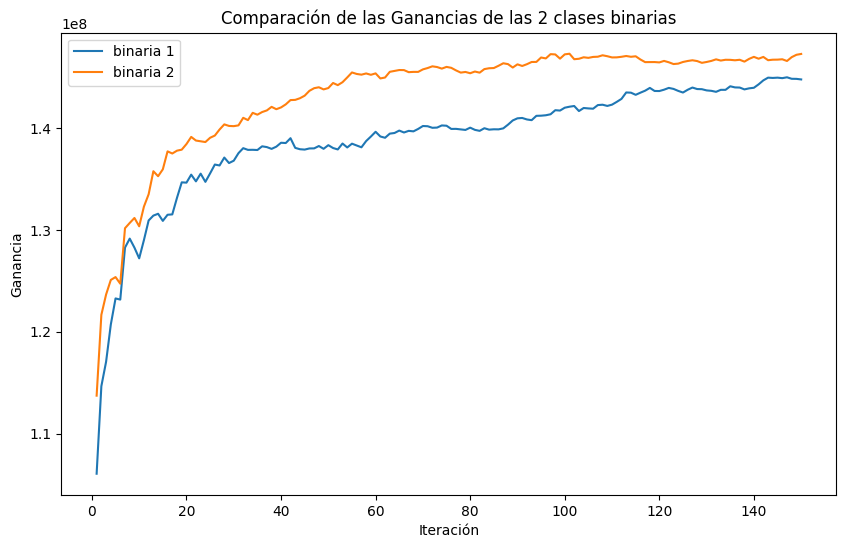

In [ ]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
#rango de eje
# plt.ylim(0, 150000000)
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

# 6.Optimizacion del Modelo


In [17]:
#version de lgb
lgb.__version__

'4.4.0'

In [18]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 2000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semilla[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior
        callbacks=[lgb.early_stopping(stopping_rounds=int(50 + 5 / learning_rate[0]))],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semilla[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_302_lgbm_v4"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-13 10:46:59,020] Using an existing study with name 'exp_302_lgbm_v4' instead of creating a new one.


In [19]:
 study.optimize(objective, n_trials=100) # subir subir

Training until validation scores don't improve for 215 rounds


[I 2024-10-13 10:49:32,190] Trial 103 finished with value: 157500000.0 and parameters: {'num_leaves': 18, 'learning_rate': 0.030296098884664127, 'min_data_in_leaf': 1379, 'feature_fraction': 0.9382523235745022, 'bagging_fraction': 0.24295942688166844}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[261]	cv_agg's valid gan_eval: 3.15e+07 + 2.53347e+06
Training until validation scores don't improve for 499 rounds


[I 2024-10-13 10:54:09,747] Trial 104 finished with value: 158214000.0 and parameters: {'num_leaves': 14, 'learning_rate': 0.01111402567895479, 'min_data_in_leaf': 1289, 'feature_fraction': 0.9067018723229597, 'bagging_fraction': 0.3024787107073835}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid gan_eval: 3.16428e+07 + 2.5497e+06
Training until validation scores don't improve for 158 rounds


[I 2024-10-13 10:55:49,182] Trial 105 finished with value: 158886000.0 and parameters: {'num_leaves': 21, 'learning_rate': 0.04598004699396141, 'min_data_in_leaf': 1194, 'feature_fraction': 0.864586443113768, 'bagging_fraction': 0.1795268355348021}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[152]	cv_agg's valid gan_eval: 3.17772e+07 + 2.49581e+06
Training until validation scores don't improve for 295 rounds


[I 2024-10-13 10:59:22,985] Trial 106 finished with value: 158228000.0 and parameters: {'num_leaves': 24, 'learning_rate': 0.020407867014856522, 'min_data_in_leaf': 1395, 'feature_fraction': 0.958545621811524, 'bagging_fraction': 0.15000994612645985}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[335]	cv_agg's valid gan_eval: 3.16456e+07 + 2.58482e+06
Training until validation scores don't improve for 136 rounds


[I 2024-10-13 11:01:01,511] Trial 107 finished with value: 157220000.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.0576287140392318, 'min_data_in_leaf': 1048, 'feature_fraction': 0.7619747230132373, 'bagging_fraction': 0.21608858063065778}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[82]	cv_agg's valid gan_eval: 3.1444e+07 + 2.81887e+06
Training until validation scores don't improve for 187 rounds


[I 2024-10-13 11:02:58,084] Trial 108 finished with value: 156996000.0 and parameters: {'num_leaves': 11, 'learning_rate': 0.03634154243238624, 'min_data_in_leaf': 971, 'feature_fraction': 0.8105248463290564, 'bagging_fraction': 0.27443918071671064}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[261]	cv_agg's valid gan_eval: 3.13992e+07 + 2.38381e+06
Training until validation scores don't improve for 219 rounds


[I 2024-10-13 11:06:00,856] Trial 109 finished with value: 158508000.0 and parameters: {'num_leaves': 17, 'learning_rate': 0.02954095030105404, 'min_data_in_leaf': 1253, 'feature_fraction': 0.9405801998533475, 'bagging_fraction': 0.24978509061809845}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[425]	cv_agg's valid gan_eval: 3.17016e+07 + 2.49588e+06
Training until validation scores don't improve for 87 rounds


[I 2024-10-13 11:07:24,539] Trial 110 finished with value: 154021000.0 and parameters: {'num_leaves': 30, 'learning_rate': 0.13241536115813257, 'min_data_in_leaf': 1550, 'feature_fraction': 0.43960098519104396, 'bagging_fraction': 0.4729951017759797}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[55]	cv_agg's valid gan_eval: 3.08042e+07 + 2.60165e+06
Training until validation scores don't improve for 306 rounds


[I 2024-10-13 11:11:36,125] Trial 111 finished with value: 158053000.0 and parameters: {'num_leaves': 8, 'learning_rate': 0.019468402186493285, 'min_data_in_leaf': 1353, 'feature_fraction': 0.8827414755009992, 'bagging_fraction': 0.4221156382557466}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[830]	cv_agg's valid gan_eval: 3.16106e+07 + 2.08939e+06
Training until validation scores don't improve for 208 rounds


[I 2024-10-13 11:14:00,179] Trial 112 finished with value: 157990000.0 and parameters: {'num_leaves': 19, 'learning_rate': 0.03156215724990371, 'min_data_in_leaf': 1130, 'feature_fraction': 0.9504521008277531, 'bagging_fraction': 0.20023186782559355}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[277]	cv_agg's valid gan_eval: 3.1598e+07 + 2.45951e+06
Training until validation scores don't improve for 237 rounds


[I 2024-10-13 11:16:57,824] Trial 113 finished with value: 158795000.0 and parameters: {'num_leaves': 19, 'learning_rate': 0.02661193843573874, 'min_data_in_leaf': 1100, 'feature_fraction': 0.9715149213350731, 'bagging_fraction': 0.2640672563286144}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[372]	cv_agg's valid gan_eval: 3.1759e+07 + 2.70167e+06
Training until validation scores don't improve for 148 rounds


[I 2024-10-13 11:18:42,247] Trial 114 finished with value: 158858000.0 and parameters: {'num_leaves': 22, 'learning_rate': 0.05091022718671817, 'min_data_in_leaf': 1162, 'feature_fraction': 0.9180840591989954, 'bagging_fraction': 0.23083083043414948}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[184]	cv_agg's valid gan_eval: 3.17716e+07 + 2.75403e+06
Training until validation scores don't improve for 166 rounds


[I 2024-10-13 11:20:55,034] Trial 115 finished with value: 158851000.0 and parameters: {'num_leaves': 12, 'learning_rate': 0.04278416432319819, 'min_data_in_leaf': 1215, 'feature_fraction': 0.8985775890996988, 'bagging_fraction': 0.3126324150176904}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[311]	cv_agg's valid gan_eval: 3.17702e+07 + 2.3576e+06
Training until validation scores don't improve for 423 rounds


[I 2024-10-13 11:25:37,657] Trial 116 finished with value: 158445000.0 and parameters: {'num_leaves': 16, 'learning_rate': 0.01339246359562573, 'min_data_in_leaf': 1488, 'feature_fraction': 0.9491777391380379, 'bagging_fraction': 0.2824079229752526}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[840]	cv_agg's valid gan_eval: 3.1689e+07 + 2.49463e+06
Training until validation scores don't improve for 123 rounds


[I 2024-10-13 11:26:56,756] Trial 117 finished with value: 157192000.0 and parameters: {'num_leaves': 25, 'learning_rate': 0.06843680369793409, 'min_data_in_leaf': 1304, 'feature_fraction': 0.9910853801952215, 'bagging_fraction': 0.2610045800138242}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[106]	cv_agg's valid gan_eval: 3.14384e+07 + 2.98994e+06
Training until validation scores don't improve for 182 rounds


[I 2024-10-13 11:29:27,486] Trial 118 finished with value: 158795000.0 and parameters: {'num_leaves': 15, 'learning_rate': 0.037637669189809785, 'min_data_in_leaf': 1438, 'feature_fraction': 0.8488024338649662, 'bagging_fraction': 0.16287127537303775}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[380]	cv_agg's valid gan_eval: 3.1759e+07 + 2.86836e+06
Training until validation scores don't improve for 242 rounds


[I 2024-10-13 11:34:20,447] Trial 119 finished with value: 157297000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.02603138588734699, 'min_data_in_leaf': 1113, 'feature_fraction': 0.38684369505620253, 'bagging_fraction': 0.3694821330549255}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[250]	cv_agg's valid gan_eval: 3.14594e+07 + 2.5535e+06
Training until validation scores don't improve for 640 rounds


[I 2024-10-13 11:40:57,714] Trial 120 finished with value: 158984000.0 and parameters: {'num_leaves': 45, 'learning_rate': 0.008466901084637227, 'min_data_in_leaf': 1255, 'feature_fraction': 0.874339230302452, 'bagging_fraction': 0.1881697158019605}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[697]	cv_agg's valid gan_eval: 3.17968e+07 + 2.61695e+06
Training until validation scores don't improve for 195 rounds


[I 2024-10-13 11:43:50,721] Trial 121 finished with value: 158298000.0 and parameters: {'num_leaves': 19, 'learning_rate': 0.03432354007349005, 'min_data_in_leaf': 998, 'feature_fraction': 0.9233470128625619, 'bagging_fraction': 0.23892061586109292}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[414]	cv_agg's valid gan_eval: 3.16596e+07 + 2.56016e+06
Training until validation scores don't improve for 509 rounds


[I 2024-10-13 11:50:28,288] Trial 122 finished with value: 158382000.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.010879249677091309, 'min_data_in_leaf': 1255, 'feature_fraction': 0.8773938964443204, 'bagging_fraction': 0.18431189629025257}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[775]	cv_agg's valid gan_eval: 3.16764e+07 + 2.96968e+06
Training until validation scores don't improve for 329 rounds


[I 2024-10-13 11:54:56,770] Trial 123 finished with value: 157990000.0 and parameters: {'num_leaves': 52, 'learning_rate': 0.017868724553717043, 'min_data_in_leaf': 1172, 'feature_fraction': 0.9631654406126987, 'bagging_fraction': 0.21013817354554007}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[249]	cv_agg's valid gan_eval: 3.1598e+07 + 2.4409e+06
Training until validation scores don't improve for 897 rounds


[I 2024-10-13 12:02:49,799] Trial 124 finished with value: 158179000.0 and parameters: {'num_leaves': 44, 'learning_rate': 0.005896971892748268, 'min_data_in_leaf': 1060, 'feature_fraction': 0.5943476634460896, 'bagging_fraction': 0.13934125614251255}. Best is trial 81 with value: 161070000.0.


Did not meet early stopping. Best iteration is:
[964]	cv_agg's valid gan_eval: 3.16358e+07 + 2.80057e+06
Training until validation scores don't improve for 83 rounds


[I 2024-10-13 12:03:38,156] Trial 125 finished with value: 153405000.0 and parameters: {'num_leaves': 39, 'learning_rate': 0.15016962010656656, 'min_data_in_leaf': 1349, 'feature_fraction': 0.9051856758992006, 'bagging_fraction': 0.18595501512022905}. Best is trial 81 with value: 161070000.0.


Early stopping, best iteration is:
[22]	cv_agg's valid gan_eval: 3.0681e+07 + 2.63322e+06
Training until validation scores don't improve for 252 rounds


[W 2024-10-13 12:04:34,739] Trial 126 failed with parameters: {'num_leaves': 21, 'learning_rate': 0.02470917921330793, 'min_data_in_leaf': 1216, 'feature_fraction': 0.9391408275239593, 'bagging_fraction': 0.22336884255186903} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-8d62ddcee055>", line 28, in objective
    cv_results = lgb.cv(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 827, in cv
    res = _agg_cv_result(cvfolds.eval_valid(feval))  # type: ignore[call-arg]
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 402, in handler_function
    ret.append(getattr(booster, name)(*args, **kwargs))
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 4413, in eval_valid
    return [
  File "/usr/local/lib/python3.10/dist-

KeyboardInterrupt: 

## 6.1 Analisis de la optimizacion

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

#7.Entrenamiento

---

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [57]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semilla[1],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 769


Observamos variables mas importanes al modelo

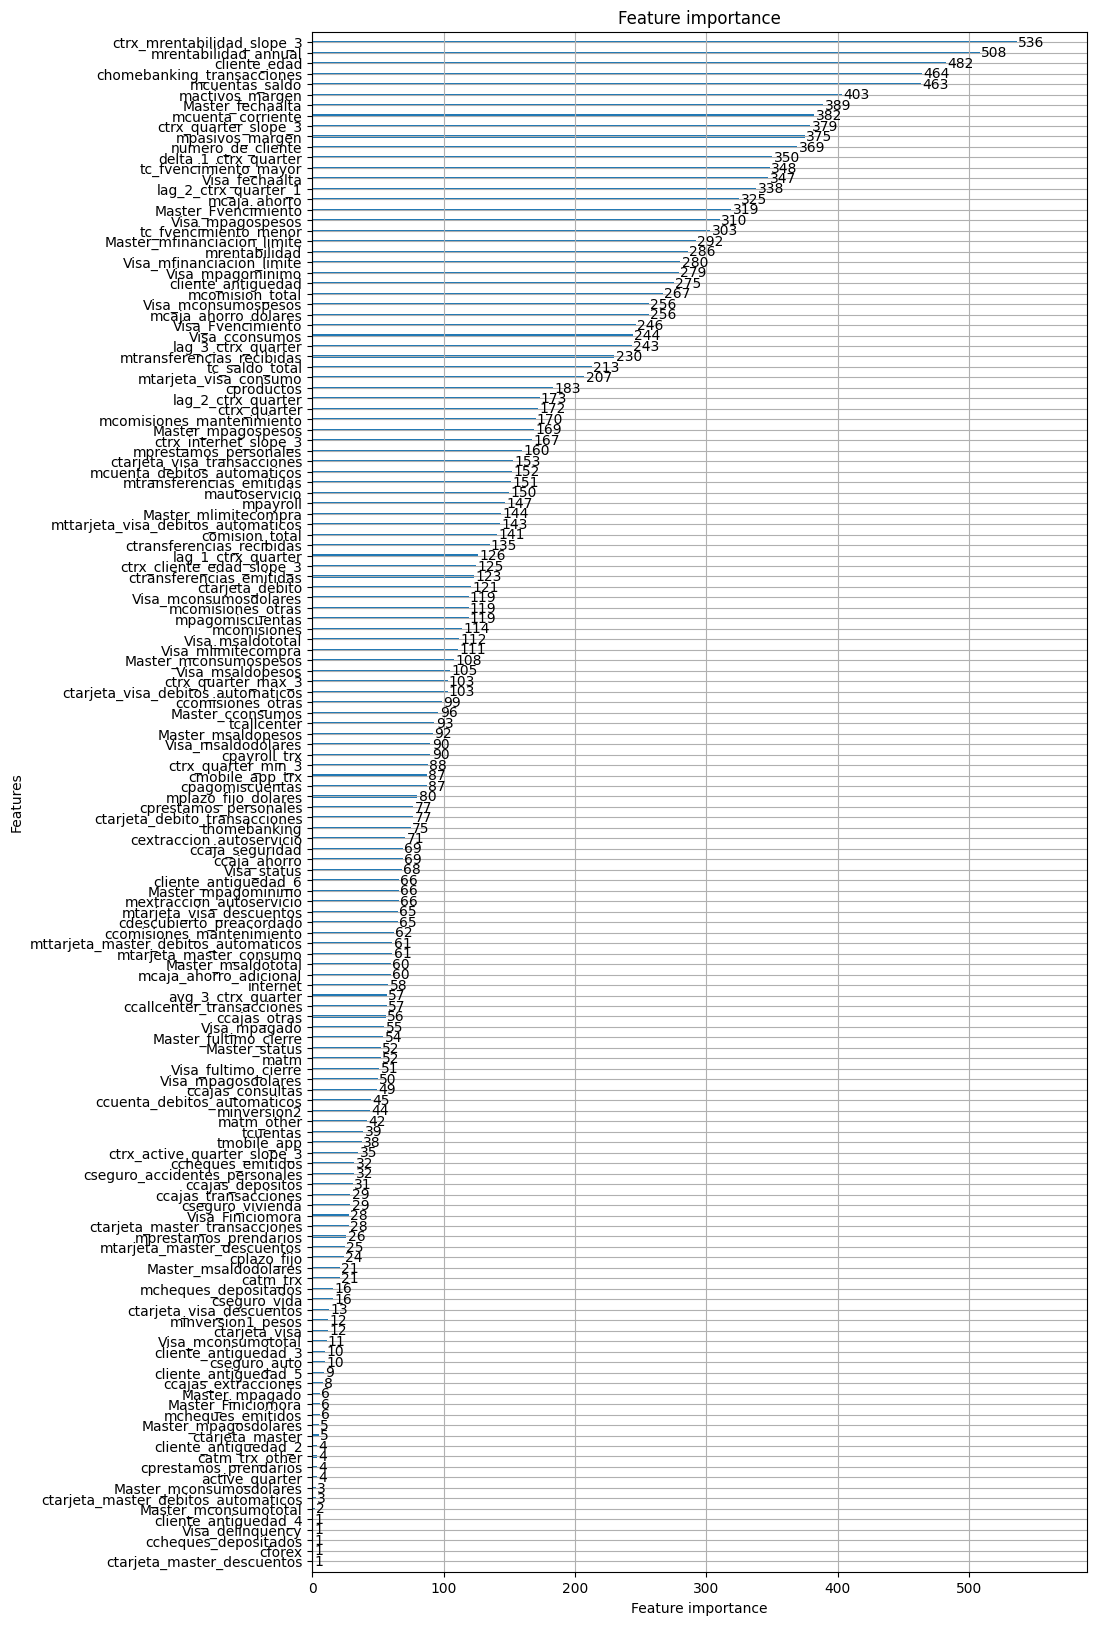

In [58]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de Dataframe:

In [59]:
importances = model_lgb.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
177,ctrx_mrentabilidad_slope_3,536
8,mrentabilidad_annual,508
5,cliente_edad,482
97,chomebanking_transacciones,464
22,mcuentas_saldo,463
...,...,...
132,Visa_delinquency,1
75,cforex,1
161,cliente_antiguedad_4,1
69,ctarjeta_master_descuentos,1


# Guardar el modelo

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [24]:
model_lgb.save_model(modelos_path + 'lgb_v4_semilla0.txt')

y recuperar el msmo desde ese formato

In [25]:
modellg_v4_v1 = lgb.Booster(model_file=modelos_path + 'lgb_v4.txt')
y_pred_lgb4 = modellg_v4_v1.predict(X_test)

In [60]:
y_pred_lgb= model_lgb.predict(X_test)

In [61]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia lgb3:", ganancia_prob(y_pred_lgb4, y_test_binaria1))
print("Ganancia LGBM:", ganancia_prob(y_pred_lgb, y_test_binaria1))


Ganancia lgb3: -91833000.0
Ganancia LGBM: -91385000.0


#Corrida de Modelo optimidazo los hiperparametros

In [62]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)



Mejor modelo: {'num_leaves': 25, 'learning_rate': 0.02816161199350139, 'min_data_in_leaf': 1036, 'feature_fraction': 0.9600261328146125, 'bagging_fraction': 0.19249067068260242}


In [ ]:
# #imputar datos, la peor de todas con la media. Randon Forest no acepta datos nulos
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Xi = imp_mean.fit_transform(train_data)
# Xif = imp_mean.fit_transform(X_test)

In [63]:
X_test.shape

(164876, 179)

In [64]:
y_pred_lgb.shape

(164876,)

In [65]:
print(y_pred_lgb)


[0.00596332 0.03373867 0.00017155 ... 0.00389997 0.00617396 0.0156415 ]


In [66]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgb)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgb[idx]

ganancia_cum = np.cumsum(ganancia)

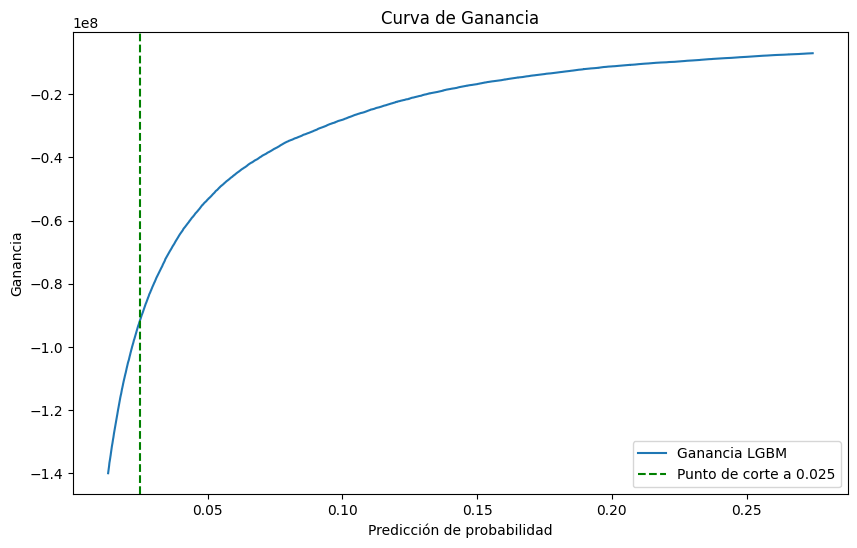

In [67]:
piso_envios = 1000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

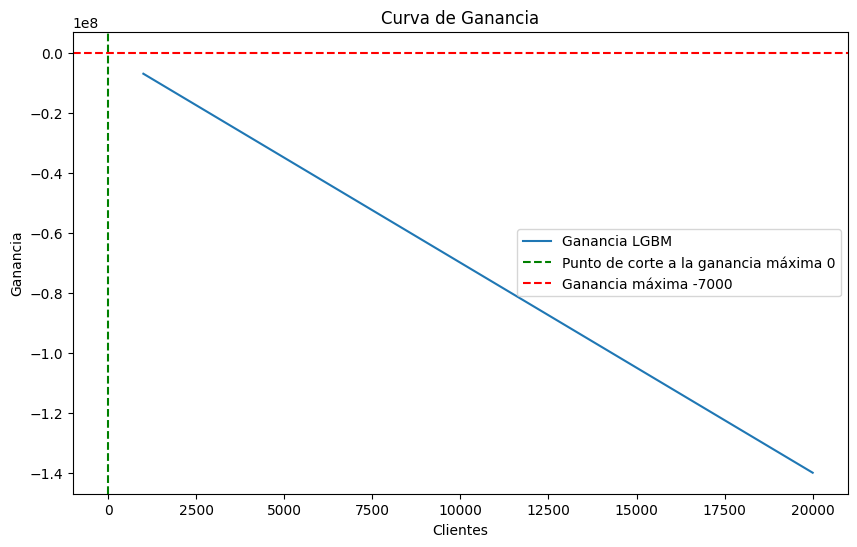

In [68]:
piso_envios = 1000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

In [85]:
#armame un archivo desde y_pred_lgb, en donde la clase 1 es  si la probbilidad es mayor a 0.025 es 1, sino es 0
clientes_elegidos = X_test[['numero_de_cliente']].copy()
clientes_elegidos['Probabilidad'] = (y_pred_lgb).astype(float)
clientes_elegidos['Predicted'] = 0
clientes_elegidos.loc[clientes_elegidos['Probabilidad'] > 0.025, 'Predicted'] = 1
clientes_elegidos.loc[clientes_elegidos['Probabilidad'] <= 0.025, 'Predicted'] = 0
clientes_elegidos


,numero_de_cliente,Probabilidad,Predicted
5,249270768,0.005963,0
11,249280836,0.033739,1
17,249328898,0.000172,0
23,249345081,0.001662,0
29,249424500,0.054147,1
...,...,...,...
981941,1596907122,0.002422,0
981942,1596910624,0.001659,0
981943,1598058646,0.003900,0
981944,1598069799,0.006174,0


In [86]:
#tengo que ordenar los clientes por Probabilidad de mayor a menor
clientes_elegidos = clientes_elegidos.sort_values(by='Probabilidad', ascending=False)
clientes_elegidos


,numero_de_cliente,Probabilidad,Predicted
234272,1069801754,0.953123,1
232076,1021275210,0.939649,1
857608,1461249806,0.938109,1
513139,612934991,0.933449,1
852830,1224175879,0.928016,1
...,...,...,...
694504,593346199,0.000002,0
504181,486163328,0.000002,0
62747,271767818,0.000002,0
514703,631044975,0.000002,0


In [78]:
#los primeros 10000 quiero que sean 1 y el resto 0
clientes_elegidos.iloc[:10000, clientes_elegidos.columns.get_loc('Predicted')] = 1
clientes_elegidos

,numero_de_cliente,Probabilidad,Predicted
234272,1069801754,0.953123,1
232076,1021275210,0.939649,1
857608,1461249806,0.938109,1
513139,612934991,0.933449,1
852830,1224175879,0.928016,1
...,...,...,...
694504,593346199,0.000002,0
504181,486163328,0.000002,0
62747,271767818,0.000002,0
514703,631044975,0.000002,0


In [87]:
clientes_elegidos.Predicted.value_counts()

,count
Predicted,
0,151821
1,13055


In [80]:
clientes_elegidos.shape


(164876, 3)

In [88]:
#borrar probabilidad
clientes_elegidos = clientes_elegidos.drop('Probabilidad', axis=1)

In [89]:

# Creamos el dataframe para entregar


version = "v17"
clientes_elegidos.to_csv(f"{dataset_path}/solucion-ganancias-{version}.csv", index=False)